In [43]:
import numpy as np
import random
import pandas as pd

#set random seed for consistency in testing
np.random.seed(0)
    
## ============== Helper Functions ==============
# Simulate two dice being rolled and their resulting rolls being summed
def DICE():
    x1 = random.randint(1,6)
    x2 = random.randint(1,6)
    return x1 + x2
def generate_statistic(event:pd.DataFrame) -> float:
    event = event[~event['departure_time'].isna()]
    #=========Mean===========
    average_waiting_time = sum(event['start_time'])/len(event)
    # total_waiting_time = sum(event['waiting_time']) 
    total_waiting_time = sum(event['departure_time'] - event['start_time'] - event['service_time'])
    average_waiting_time = total_waiting_time/len(event)
    #=========Minimum===========
    minimum_waiting_time = min(event['service_time']-event['start_time'])
    #=========Variance===========
    variance_waiting_time = (total_waiting_time - average_waiting_time)**2/len(event)
    #=========Standard Deviation===========
    standard_deviation_waiting_time = variance_waiting_time**(1/2)
    #=========Confidence Interval===========
    # 95% confidence interval
    confidence_interval_waiting_time = [average_waiting_time - 1.96*(standard_deviation_waiting_time/(len(event)**(1/2))),average_waiting_time + 1.96*(standard_deviation_waiting_time/(len(event)**(1/2)))]
   
    return average_waiting_time, minimum_waiting_time,variance_waiting_time, standard_deviation_waiting_time, confidence_interval_waiting_time
## ============== Event class ==============         
class callEvent:
    def __init__(self, time, event_type, product_type, start_time, service_time=None, departure_time=None):
        self.time = time
        self.type = event_type
        self.product_type = product_type
        self.start_time = start_time
        self.service_time = service_time
        self.departure_time = departure_time
        
    def __str__(self):
        return f'callEvent(time: {self.time}, type: {self.type}, product_type: {self.product_type}, service_time: {self.service_time}, departure_time: {self.departure_time})'
    
def generate_arrival(time):
    type_roll = DICE()
    product_type = 'car_stereo' if type_roll <= 4 else 'other' # car-stereo/other
    return callEvent(time=time, event_type='arrival', product_type=product_type, start_time=time)


## ============== Call Center Class ==============
# Class specifics:
# - time is measured in minutes
# - customers refer to callers

# Random variables:
#1. Time between arrivals of calls at the center = (DICE * 0.333) minutes, done in wrapper.
#2. The delay at the IVR unit = (DICE * 0.3) minutes.
#3. The delay for car-stereo call processing = (DICE * 2) minutes.
#4. The delay for other-product call processing= (DICE) minutes. 

class callCenter():# a call center simulation class
    def __init__(self, IVR_MAX=10):
        self.IVR_queue = 0 # a queue before others have decided to go to car-stereo or other.
        self.car_stereo_queue = []
        self.other_queue = []
        
        self.cs_status ='idle'
        self.o_status = 'idle'
        
        self.clock = 0
        self.event_calendar = pd.DataFrame(columns=['time','type','product_type','start_time','service_time','departure_time'])
        self.event_history = pd.DataFrame(columns=['time','type','product_type','start_time','service_time','departure_time'])
        
        self.IVR_max = IVR_MAX # maximum queue length for call arrivals to splitter

        
    def add_event(self, event):
        # Add a new event to the event calendar 
        new_event = pd.DataFrame({'time': [event.time], 'type': [event.type], 'product_type': [event.product_type],
                                  'start_time': [event.start_time],'service_time': [event.service_time],
                                  'departure_time': [event.departure_time]})
        self.event_calendar = pd.concat([self.event_calendar, new_event], ignore_index=True)

        
    def log(self, event):
        new_event = pd.DataFrame({'time': [event.time], 'type': [event.type], 'product_type': [event.product_type],
                                  'start_time': [event.start_time],'service_time': [event.service_time],
                                  'departure_time': [event.departure_time]})
        self.event_history = pd.concat([self.event_history, new_event], ignore_index=True)
        
        
    def run_simulation(self, end_time): # example: if time is greater than 5*60 = 300 minutes, then call center is closed
        while (self.event_calendar.empty == False) and (self.clock < end_time):
            # Order events by time and pop top
            self.event_calendar = self.event_calendar.sort_values(by="time")
            curr_event = callEvent(time=self.event_calendar.iloc[0].time, event_type=self.event_calendar.iloc[0].type, 
                                   product_type=self.event_calendar.iloc[0].product_type,
                                   start_time=self.event_calendar.iloc[0].start_time,
                                   service_time=self.event_calendar.iloc[0].service_time, 
                                   departure_time=self.event_calendar.iloc[0].departure_time)
            self.event_calendar = self.event_calendar.iloc[1:]
            
            self.clock = curr_event.time
            self.log(curr_event)
            self.handle_event(curr_event)
            
            
    def handle_event(self, event):
        if event.type == 'arrival':
            # If the parallel switching queue is too long, the caller hangs up
            if self.IVR_queue > self.IVR_max:
                busy_event = callEvent(time=self.clock, event_type='busy', product_type=event.product_type,
                                       start_time=event.start_time, service_time=0, departure_time=self.clock)
                self.add_event(busy_event) # This doesn't need to be processed in event type as it is just logged
                return

            # If the IVR queue is empty put it through to the next series after delay
            # Add event to IVR queue
            IVR_delay = DICE() * 0.3
            IVR_event = callEvent(time=self.clock+IVR_delay, event_type='IVR', product_type=event.product_type, 
                                  start_time=event.start_time, service_time=IVR_delay, departure_time=None)
            # Queue keeps track of current IVR queue, the IVR event makes sure it gets taken care of by the event handler
            self.IVR_queue += 1 # IVR queue processing contains all current IVR_event including if it's empty 
            self.add_event(IVR_event)
            
        elif event.type == 'IVR':
            self.IVR_queue -= 1
            
            # Split the IVR queue into car-stereo and others queue separation
            if event.product_type == 'car_stereo':
                if self.cs_status == 'idle':
                    self.cs_status = 'busy'
                    
                    # Add event to car-stereo queue
                    car_stereo_delay = DICE() * 2
                    self.schedule_service(event, 'car_stereo_queue', car_stereo_delay)
                else:
                    self.car_stereo_queue.append(event)
                    
            if event.product_type == 'other':
                if self.o_status == 'idle':
                    self.o_status = 'busy'
                    # Add event to other queue
                    other_delay = DICE()
                    self.schedule_service(event, 'other_queue', other_delay)
                else:
                    self.other_queue.append(event)
                    
        ## Handle car stereo queue and operation
        elif event.type == 'car_stereo_queue':
            self.cs_status = 'idle'
            self.service_completion(event, self.car_stereo_queue, DICE() * 2)
        
        # Handle other queue and operation
        elif event.type == 'other_queue':
            self.other_state = 'idle'
            self.service_completion(event, self.other_queue, DICE())
            
            
    def schedule_service(self, event, queue_type, delay):
        # Function to schedule a service event based on the delay
        new_event = callEvent(time=self.clock + delay, event_type=queue_type, 
                              product_type=event.product_type, start_time=event.start_time, 
                              service_time=delay, departure_time=None)
        self.add_event(new_event)

    # Queue handling/status checking and departure creation
    def service_completion(self, event, queue, delay):
        # print(f'{event.product_type}: {len(queue)}')
        if len(queue) > 0:
            next_event = queue.pop(0)
            if event.product_type == 'car_stereo':
                self.cs_status = 'busy'
                self.schedule_service(next_event, 'car_stereo_queue', delay)
            else:
                self.o_status = 'busy'
                self.schedule_service(next_event, 'other_queue', delay)
                
        departure_event = callEvent(time=self.clock, event_type='departure', product_type=event.product_type, 
                                    start_time=event.start_time, service_time=event.service_time + delay, 
                                    departure_time=self.clock + delay)
        self.log(departure_event)    
            

In [64]:
# ==== Main ====
np.random.seed(0)
end_time = 300
IVR_MAX = 10
cc = callCenter(IVR_MAX)
event_history_list = []
time = 0
df = pd.DataFrame(columns=['iteration','car stereo rep', 'other rep','total reps','waiting percentage'])

for i in range(30):
    # print(f"\tround {i}")
    cc = callCenter(IVR_MAX)
    while time < end_time:
        cc.add_event(generate_arrival(time))
        time += DICE() * 0.333
        
    time = 0
    cc.run_simulation(end_time)
    #=========Analysis===========
    event_history_list.append(cc.event_history)
    new_row = {'iteration': int(i+1),
               'car stereo rep':int(len(cc.car_stereo_queue)),
               'other rep':int(len(cc.other_queue)),
               'total reps':int(len(cc.car_stereo_queue)+len(cc.other_queue)),
               'waiting percentage':len(cc.event_history[~cc.event_history['departure_time'].isna()]['departure_time'])/len(cc.event_history)*100}
    # df = df.append(new_row, ignore_index=True)
    df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [65]:
#export df to csv
df.to_csv('statistical_result.csv',index=False)


In [60]:
event_history_df = pd.concat(event_history_list, ignore_index=True)

In [61]:
awt,minwt, vwt,sdwt,ciwt = generate_statistic(event_history_df)

In [62]:
result_df = pd.DataFrame({'average_waiting_time': [awt], 'minimum_waiting_time': [minwt], 'variance_waiting_time': [vwt], 'standard_deviation_waiting_time': [sdwt], 'confidence_interval_waiting_time': [ciwt]})
result_df

,average_waiting_time,minimum_waiting_time,variance_waiting_time,standard_deviation_waiting_time,confidence_interval_waiting_time
0,68.733588,-273.712,8.002977e+06,2828.953396,"[-65.90481165554628, 203.37198736309335]"


# Graph

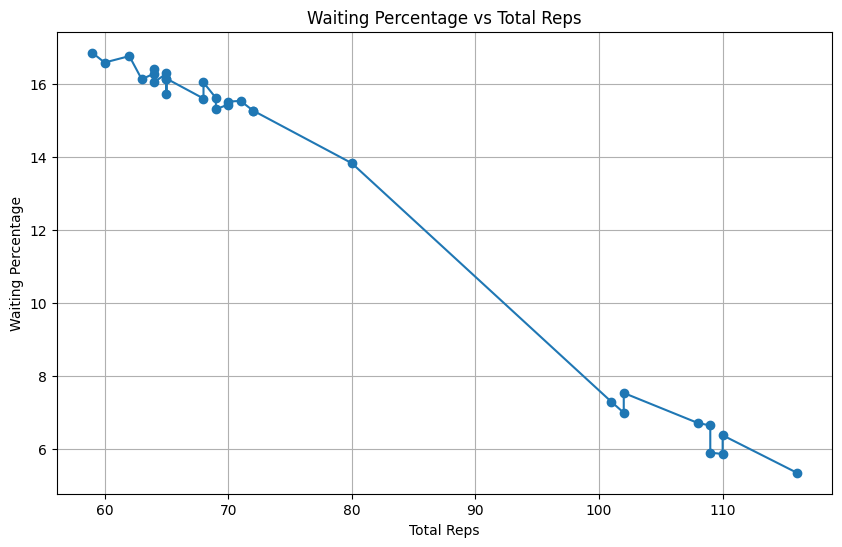

In [69]:
import matplotlib.pyplot as plt

# Sort df by 'total reps'
df_sorted = df.sort_values(by='total reps')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['total reps'], df_sorted['waiting percentage'], '-o')  # '-o' adds points on each data point
plt.xlabel('Total Reps')
plt.ylabel('Waiting Percentage')
plt.title('Waiting Percentage vs Total Reps')
plt.grid(True)
plt.show()
